# Example notebook for S6 - Generation of spectral indexes 

Practical activity during the [Geology & Planetary Mapping Winter School Program](https://www.planetarymapping.eu/375/program.html)
- **Name** : S6 - Generation of spectral indexes
- **Lead**: Francesca Altieri (INAF); Francesca Zambon (INAF)
- **Description** :  Exploiting spectral data to generate compositional indexes.
- **Instructors** : Cristian Carli (INAF); Sabrina Ferrari (UNIPD); Mario D'Amore (DLR); Jacopo Nava (UNIPD)
- **Data preparation** : Francesca Altieri (INAF); Francesca Zambon (INAF)
- **Data Source** : Data from NASA MESSENGER/MDIS camera from Mercury. Data available here below.
    * [MESSENGER > Explore > Quick Map-Orbital-Data](https://messenger.jhuapl.edu/Explore/Quick-Map-Orbital-Data.html)
    * [MESSENGER Imaging Node Mission Page](https://pds-imaging.jpl.nasa.gov/portal/messenger_mission.html)
    * [PDS Geosciences Node Data and Services: MESSENGER Mission](https://pds-geosciences.wustl.edu/missions/messenger/index.htm)
- **Code** : Mario D'Amore (DLR, mario.damore@dlr.de)

This project has received funding from the European Union's Horizon 2020 research and innovation programme under grant agreement No 776276 & No. 871149.

![european flag wikicommon](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b7/Flag_of_Europe.svg/320px-Flag_of_Europe.svg.png)

Exploiting spectral data to generate compositional indexes. See attacched presentations.

## Setup working enviroment

You can install python modules in any way you want to run this notebook, if you have the following packages available :

```
pip install jupyterlab numpy pandas matplotlib ipython rasterio skimage
```

**The easy way** is to install anaconda for your OS > [Installation — Anaconda documentation](https://docs.anaconda.com/anaconda/install/) then :

```
## create an enviroment with the desired packages
conda create -n spectral-indexes-workshop -c conda-forge jupyterlab numpy pandas matplotlib ipython rasterio scikit-image

## activate it
conda acrivate spectral-indexes-workshop

## run jupyter lab
jupyter lab

## then open this ipynb : ipython notebook
```

In [1]:
# %load https://gist.githubusercontent.com/kidpixo/2ec078d09834b5aa7869/raw/830fa74ee37dcd791ea6ff58a1f1ea8cc1207762/ipython_inizialization.py
# useful imports
import numpy as np
import pandas as pd

# plotting
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# useful for displaying html, images and so on
from IPython.display import display

## Read the image

See [Python Quickstart — rasterio documentation](https://rasterio.readthedocs.io/en/latest/quickstart.html)


In [2]:
import rasterio

dataset = rasterio.open('Data/Mercury_test_area.dat')

/home/kidpixo/miniconda3/envs/raw2cal/lib/python3.8/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [3]:
dataset.bounds

BoundingBox(left=0.0, bottom=1785.0, right=1544.0, top=0.0)

In [4]:
# they start with 1, python is 0 indexed
dataset.indexes

(1, 2, 3, 4, 5, 6, 7, 8)

In [5]:
MDIS_bands = [433.2,  479.9, 558.9, 628.8, 748.7,828.4,898.8,996.2,]

# create a dictionary with all bands
# round band name to integer, easyier to address them
bands = {int(band):dataset.read(ind)  for band,ind in zip(MDIS_bands,dataset.indexes)}

# # alternative
# bands = {MDIS_bands[ind]:dataset.read(ind-1)  for ind in range(dataset.indexes[-1])}



In [6]:
bands.keys()

dict_keys([433, 479, 558, 628, 748, 828, 898, 996])

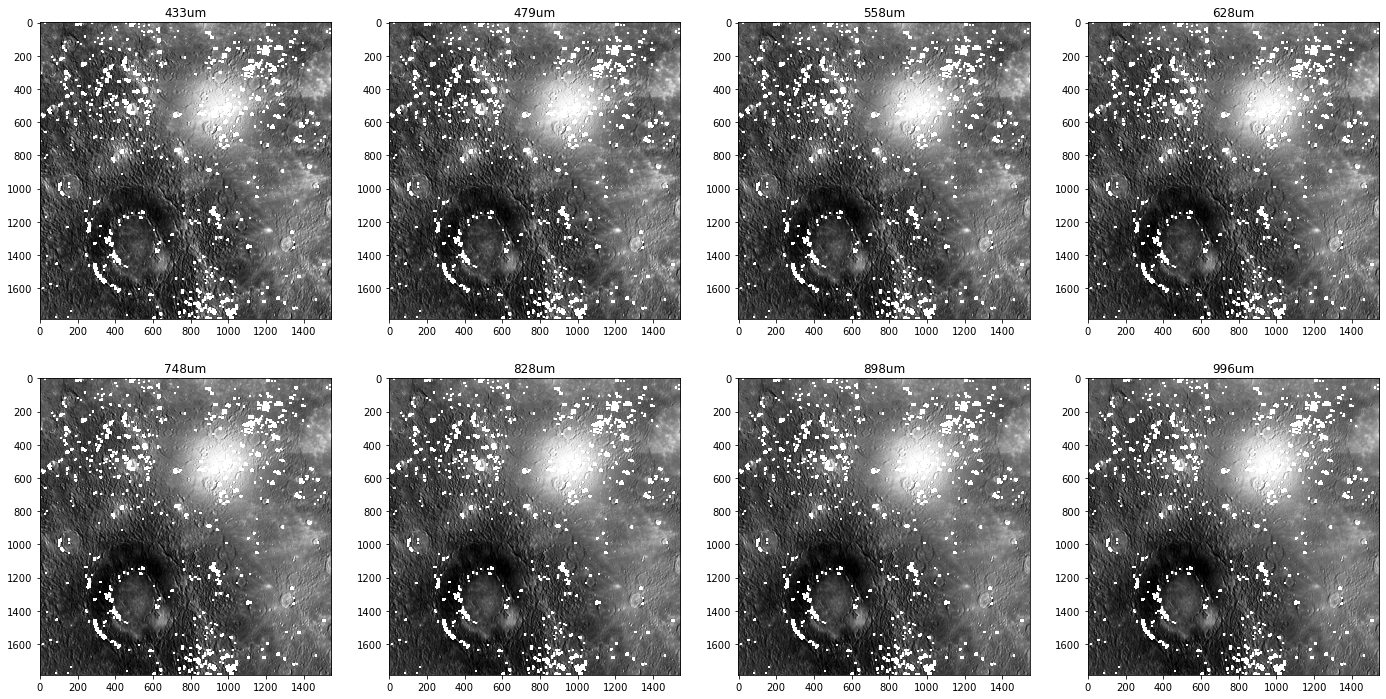

In [7]:
def plot_band(img,title,ax,cmap="Greys_r"):
    from skimage import exposure
    # rescale intensity
    p2, p98 = np.nanpercentile(img, (2, 99.5))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    # historgram equalization
#     img_rescale = exposure.equalize_hist(img, mask=np.isfinite(bands[index]))
    # same image as input
#     img_rescale = img
    ax.imshow( img_rescale,cmap=cmap,aspect='auto')
#     ax.imshow(bands[index],cmap="Greys_r",aspect='auto')
    ax.set_title(title)

fig, axs = plt.subplots(nrows=2,ncols=4,figsize=[24,12])
# zip the nrows*ncols axes and all the kes
for a,k in zip(axs.flatten(),bands.keys()):
    plot_band(bands[k],f'{k}um',a)


In [8]:
bands_3d = np.stack([v for k,v in bands.items()])
bands_3d.shape

(8, 1785, 1544)

In [10]:
bands_df = pd.DataFrame(
index=MDIS_bands,
data=bands_3d.reshape(bands_3d.shape[0],bands_3d.shape[1]*bands_3d.shape[2])
)
bands_df.shape

(8, 2756040)

<AxesSubplot:>

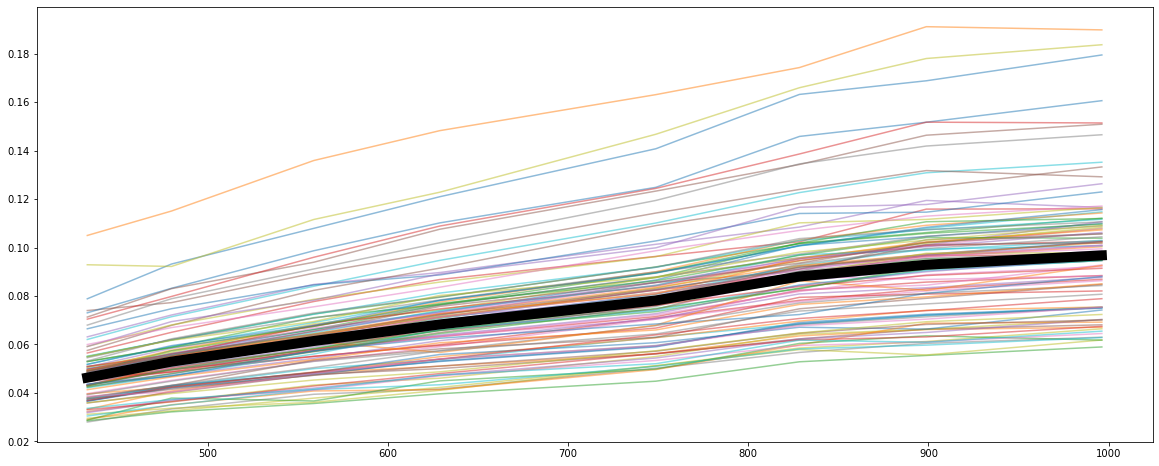

In [12]:
ax = bands_df.sample(100,axis=1).plot(figsize=[20,8], legend=False,alpha=0.5)
bands_df.mean(axis=1).plot(legend=False,ax=ax,lw=10,c='black')

In [12]:
list(enumerate(bands.keys()))

[(0, 433),
 (1, 479),
 (2, 558),
 (3, 628),
 (4, 748),
 (5, 828),
 (6, 898),
 (7, 996)]

In [16]:
band1 = 433
band2 = 996
band_ratio = (bands[band2]-bands[band1])/((band2-band1)*bands[band1])
band_ratio_df = pd.DataFrame(band_ratio.flatten()) 
display(band_ratio_df.describe())

,0
count,2.737598e+06
mean,1.938787e-03
std,2.801560e-04
min,-1.143728e-03
25%,1.764802e-03
50%,1.956237e-03
75%,2.122895e-03
max,4.986714e-03


Assign threeshold based on mean and standard deviation

In [20]:
band_ratio_mean = band_ratio_df.mean()[0]
band_ratio_std = band_ratio_df.std()[0]
threeshold_1 = band_ratio_mean + band_ratio_std * -2
threeshold_2 = band_ratio_mean + band_ratio_std * -1
threeshold_3 = band_ratio_mean + band_ratio_std * 1
threeshold_4 = band_ratio_mean + band_ratio_std * 2
print(f'{threeshold_1=:.4f}')
print(f'{threeshold_2=:.4f}')
print(f'{threeshold_3=:.4f}')
print(f'{threeshold_4=:.4f}')

threeshold_1=0.0014
threeshold_2=0.0017
threeshold_3=0.0022
threeshold_4=0.0025


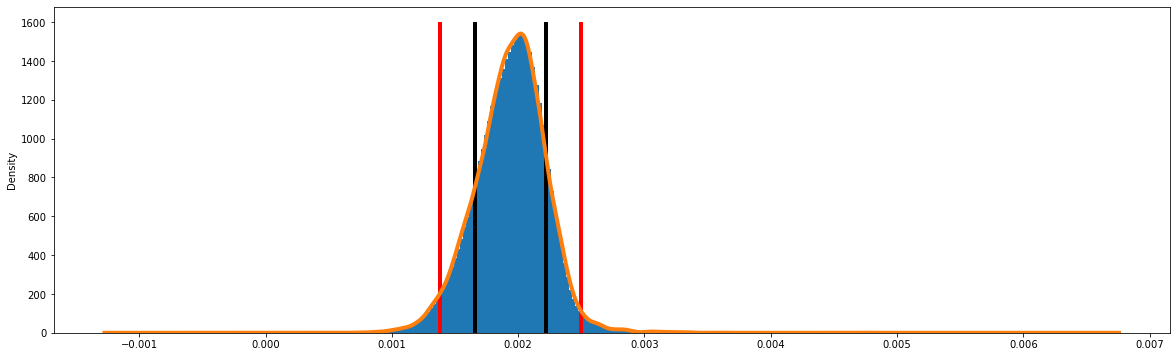

In [21]:
ax = band_ratio_df.plot.hist(bins=256,figsize=[20,6],density=1,legend=False)
band_ratio_df.sample(10000).plot.kde(ax=ax,lw=4,legend=False)
ax.vlines(threeshold_1,ymin=0,ymax=1600,color='red',lw=4)
ax.vlines(threeshold_2,ymin=0,ymax=1600,color='black',lw=4)
ax.vlines(threeshold_3,ymin=0,ymax=1600,color='black',lw=4)
ax.vlines(threeshold_4,ymin=0,ymax=1600,color='red',lw=4)
# ax.set_xlim([0,1])

In [22]:
copy_band_ratio = band_ratio.copy()
copy_band_ratio[band_ratio < threeshold_1                                ] = 0
copy_band_ratio[(threeshold_1 < band_ratio) & (band_ratio < threeshold_2)] = 1
copy_band_ratio[(threeshold_2 < band_ratio) & (band_ratio < threeshold_3)] = 2
copy_band_ratio[(threeshold_3 < band_ratio)                              ] = 3

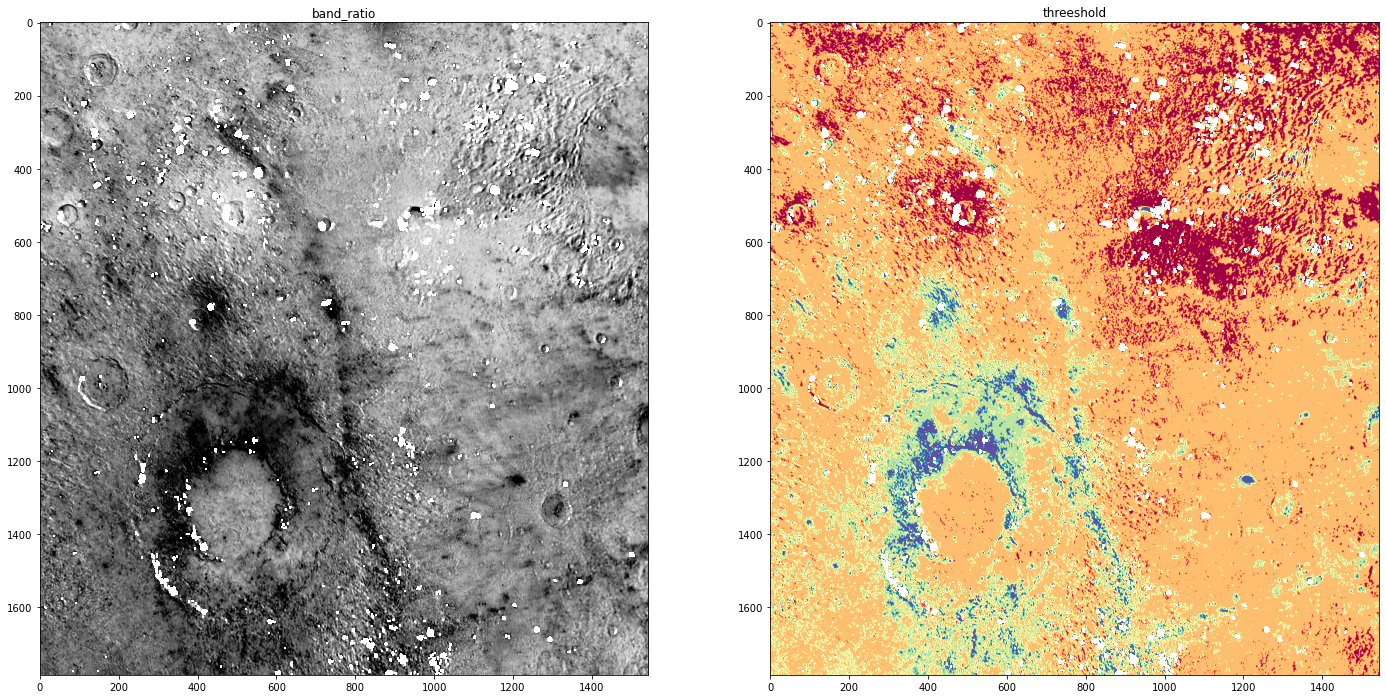

In [23]:
fig, ax = plt.subplots(ncols=2,figsize=[24,12])
plot_band(band_ratio,'band_ratio',ax[0])
plot_band(copy_band_ratio,'threeshold',ax[1],cmap="Spectral_r")